In [1]:
## import libraries
import re
import io
import nltk
import string
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from google.colab import files
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob.sentiments import NaiveBayesAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%matplotlib inline 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
##upload data
original_data = files.upload()
data = pd.read_excel(io.BytesIO(original_data['Case Study Data-Aug 27, 2021.xlsx']))
data['Date'] = [d.date() for d in data['IST']]
data['Time'] = [d.time() for d in data['IST']]
data.head(2)

Saving Case Study Data-Aug 27, 2021.xlsx to Case Study Data-Aug 27, 2021 (25).xlsx


,SocialNetwork,IST,Message,Date,Time
0,TWITTER,2021-04-03 11:42:51.550,"""Menu lgda meri zindagi vich kuch galat ho rha...",2021-04-03,11:42:51.550000
1,TWITTER,2021-03-25 00:34:06.154,#A52 #Samsung #A72 #SamsungGalaxyA52,2021-03-25,00:34:06.154000


In [3]:
print("Before {}".format(len(data)))
dataAfter = data.dropna() # removes all null
print("After {}".format(len(dataAfter)))
dataAfter.reset_index(inplace = True)
dataAfter = dataAfter.drop(['IST','index'], 1)
print("The shape of DataFrame is ", dataAfter.shape)
df = dataAfter.copy()

Before 10000
After 9992
The shape of DataFrame is  (9992, 4)


## Introduction to Topic Modelling

In [4]:
##This function will extract the twitter handles of retweed people, This function will extract the twitter handles of people mentioned in the tweet, This function will extract hashtags
def find_retweeted(tweet):
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   
  
# make new columns for retweeted usernames, mentioned usernames and hashtags
df['retweeted'] = df.Message.apply(find_retweeted)
df['mentioned'] = df.Message.apply(find_mentioned)
df['hashtags'] = df.Message.apply(find_hashtags)

In [5]:
df.head()

,SocialNetwork,Message,Date,Time,retweeted,mentioned,hashtags
0,TWITTER,"""Menu lgda meri zindagi vich kuch galat ho rha...",2021-04-03,11:42:51.550000,[],"[@AseesKaur, @RubiDilaik]","[#RubinaDilaik, #AseesKaur, #ParasChabbra, #Ga..."
1,TWITTER,#A52 #Samsung #A72 #SamsungGalaxyA52,2021-03-25,00:34:06.154000,[],[],"[#A52, #Samsung, #A72, #SamsungGalaxyA52]"
2,TWITTER,#AndroidGurujiStyleUnboxing\n#SamsungGalaxyA52...,2021-03-22,13:56:25.272000,[],"[@AbishakeR5, @the_pride_grv]","[#AndroidGurujiStyleUnboxing, #SamsungGalaxyA5..."
3,TWITTER,#AskArun What can I get #Samsung Galaxy A52 I ...,2021-04-02,13:04:07.020000,[],[],"[#AskArun, #Samsung]"
4,TWITTER,#awesomeisforeveryone,2021-03-29,11:33:12.678000,[],[],[#awesomeisforeveryone]


In [6]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = df.loc[df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]

# create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame([hashtag for hashtags_list in hashtags_list_df.hashtags for hashtag in hashtags_list], columns=['hashtag'])
flattened_hashtags_df.shape

(12033, 1)

In [7]:
min_appearance = 10 # take hashtags which appear at least this amount of times
# find popular hashtags - make into python set for efficiency
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size().reset_index(name='counts').sort_values('counts', ascending=False).reset_index(drop=True)
popular_hashtags_set = popular_hashtags[popular_hashtags.counts>=min_appearance]['hashtag']
print(popular_hashtags_set)

0                #GalaxyA52
1                #GalaxyA72
2                  #GalaxyA
3        #stufflistingsarmy
4     #AwesomeIsForEveryone
              ...          
69            #SamsungIndia
70                      #HD
71             #GalaxyBuds2
72        #SamsungGalaxyF12
73                   #india
Name: hashtag, Length: 74, dtype: object


In [8]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [9]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [10]:
df['clean_tweet'] = df.Message.apply(clean_tweet)
df.head(10)

,SocialNetwork,Message,Date,Time,retweeted,mentioned,hashtags,clean_tweet
0,TWITTER,"""Menu lgda meri zindagi vich kuch galat ho rha...",2021-04-03,11:42:51.550000,[],"[@AseesKaur, @RubiDilaik]","[#RubinaDilaik, #AseesKaur, #ParasChabbra, #Ga...",menu lgda meri zindagi vich kuch galat ho rha...
1,TWITTER,#A52 #Samsung #A72 #SamsungGalaxyA52,2021-03-25,00:34:06.154000,[],[],"[#A52, #Samsung, #A72, #SamsungGalaxyA52]",#a #samsung #a #samsunggalaxya
2,TWITTER,#AndroidGurujiStyleUnboxing\n#SamsungGalaxyA52...,2021-03-22,13:56:25.272000,[],"[@AbishakeR5, @the_pride_grv]","[#AndroidGurujiStyleUnboxing, #SamsungGalaxyA5...",#androidgurujistyleunboxing #samsunggalaxya #g...
3,TWITTER,#AskArun What can I get #Samsung Galaxy A52 I ...,2021-04-02,13:04:07.020000,[],[],"[#AskArun, #Samsung]",#askarun get #samsung galaxi accept condit exc...
4,TWITTER,#awesomeisforeveryone,2021-03-29,11:33:12.678000,[],[],[#awesomeisforeveryone],#awesomeisforeveryone
5,TWITTER,#AwesomeIsForEveryone \n#GalaxyA52 #stufflisti...,2021-03-24,12:49:04.434000,[],"[@stufflistings, @SamsungMobile, @SamsungIndia]","[#AwesomeIsForEveryone, #GalaxyA52, #stufflist...",#awesomeisforeveryone #galaxya #stufflistingsa...
6,TWITTER,#Best phone this price rangetrakintech-samsung...,2021-03-26,08:31:59.953000,[],[],"[#Best, #TrakinTech, #KeepTrakin]",#best phone price rangetrakintech samsung gala...
7,TWITTER,#BESTPHONE #GALAXYA52 @SamsungIndia,2021-04-03,20:47:00.174000,[],[@SamsungIndia],"[#BESTPHONE, #GALAXYA52]",#bestphone #galaxya
8,TWITTER,#bestphoneofthisprice #Tracin #https://gleam.i...,2021-03-25,23:58:37.705000,[],[],"[#bestphoneofthisprice, #Tracin, #https, #Trak...",#bestphoneofthisprice #tracin # #trakintech #k...
9,TWITTER,#BLQuickReview of the #SamsungA52 and #Samsung...,2021-03-27,17:00:00.356000,[],[@malabhargava],"[#BLQuickReview, #SamsungA52, #SamsungA72]",#blquickreview #samsunga #samsunga read detail...


## Exploratory Data Analysis

In [11]:
def NaiveBaiyes_Sentimental(sentence):
    blob = TextBlob(sentence, analyzer=NaiveBayesAnalyzer())
    NaiveBayes_SentimentScore=blob.sentiment.classification
    return NaiveBayes_SentimentScore

In [12]:
# VADER sentiment analysis tool for getting Compound score.
def sentimental(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    return score

# VADER sentiment analysis tool for getting pos, neg and neu.
def sentimental_Score(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    if score >= 0.5:
        return 'pos'
    elif (score > -0.5) and (score < 0.5):
        return 'neu'
    elif score <= -0.5:
        return 'neg'

In [13]:
# Seperating negatives and positives into different dataframes for creating a 'Wordcloud'
df['Sentiment_Score']=df['Message'].apply(lambda x: sentimental_Score(x))
pos = df.loc[df['Sentiment_Score'] == 'pos']
neg = df.loc[df['Sentiment_Score'] == 'neg']

- Stemming function for stemming of different form of words which will be used 
by 'create_Word_Corpus()' function.
- PorterStemmer from nltk.stem is used for stemming.

In [14]:
def stemming(tokens):
    ps=PorterStemmer()
    stem_words=[]
    for x in tokens:
        stem_words.append(ps.stem(x))
    return stem_words

To Generate a word corpus following steps are performed inside the function 'create_Word_Corpus(df)'

- Step 1 :-  Iterating over the 'summary' section of reviews such that we only get important content of a review.
- Step 2 :- Converting the content into Lowercase.
- Step 3 :- Using nltk.tokenize to get words from the content.
- Step 4 :- Using string.punctuation to get rid of punctuations.
- Step 5 :- Using stopwords from nltk.corpus to get rid of stopwords.
- Step 6 :- Stemming of Words.
- Step 7 :- Finally forming a word corpus and returning the word corpus.

In [15]:
def create_Word_Corpus(df):
    words_corpus = ''
    for val in df["Message"]:
        text = val.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in string.punctuation]
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = stemming(tokens)
        for words in tokens:
            words_corpus = words_corpus + words + ' '
    return words_corpus

In [16]:
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    plt.savefig('wordclouds.png', facecolor='k', bbox_inches='tight')

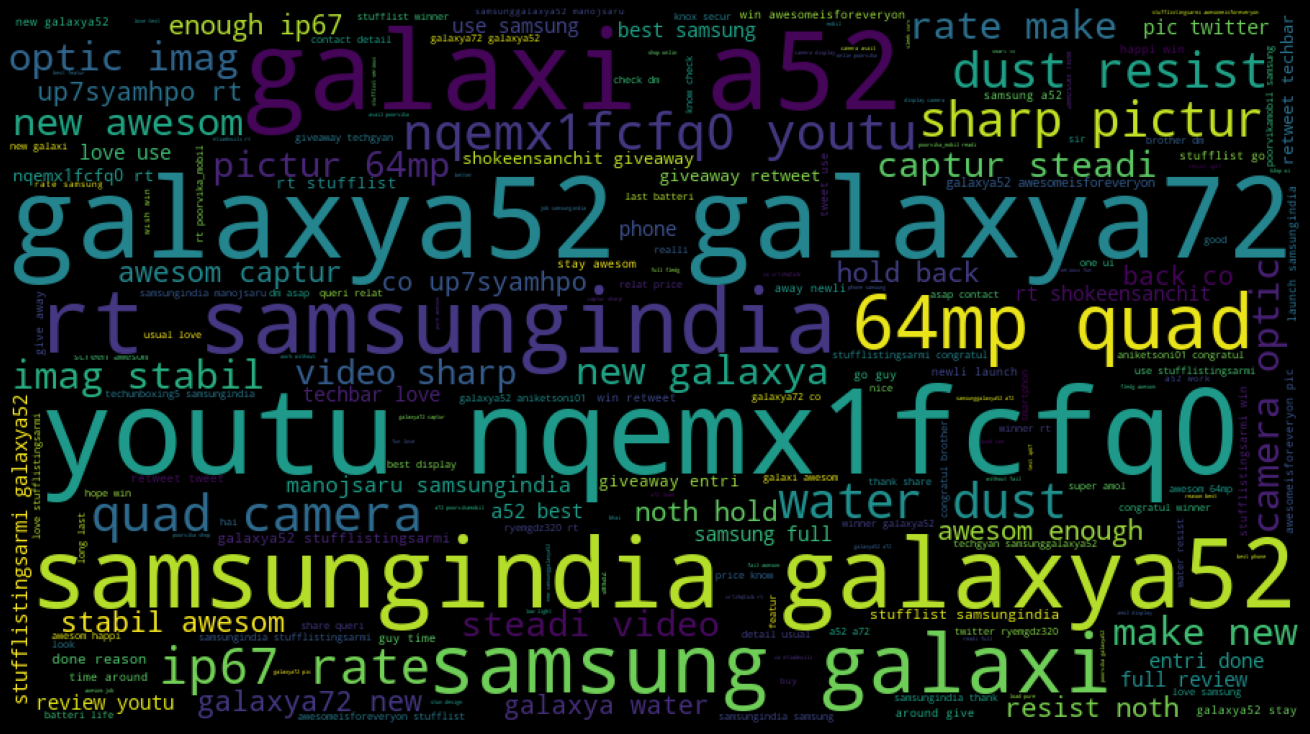

<Figure size 432x288 with 0 Axes>

In [17]:
pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(pos))
plot_Cloud(pos_wordcloud)

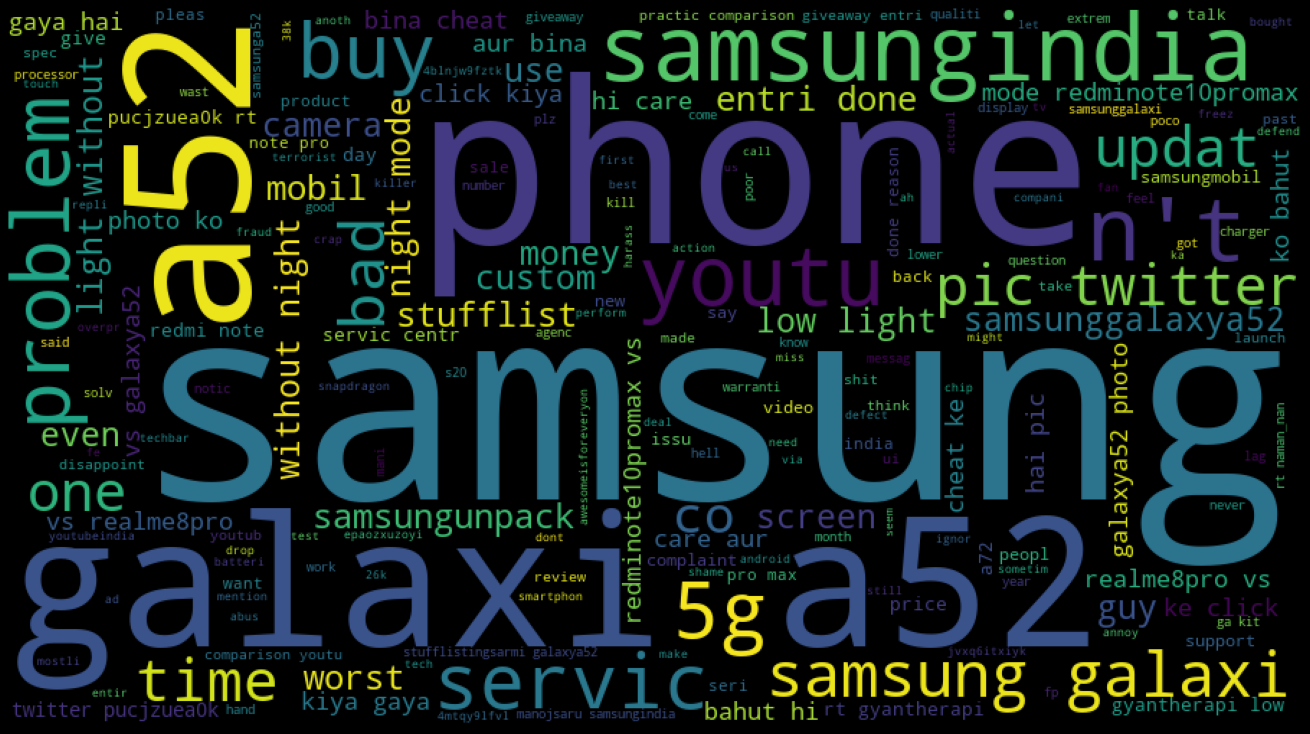

<Figure size 432x288 with 0 Axes>

In [18]:
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neg))
plot_Cloud(neg_wordcloud)

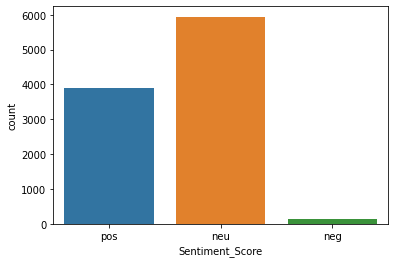

In [19]:
sns.countplot(x='Sentiment_Score', data=df)

In [20]:
# function to get the subjectivity
def getsubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# function to get the polarity
def getpolarity(text):
  return TextBlob(text).sentiment.polarity

In [21]:
df['Subjectivity'] = df['Message'].apply(getsubjectivity)
df['Polarity'] = df['Message'].apply(getpolarity)

In [22]:
df.head()

,SocialNetwork,Message,Date,Time,retweeted,mentioned,hashtags,clean_tweet,Sentiment_Score,Subjectivity,Polarity
0,TWITTER,"""Menu lgda meri zindagi vich kuch galat ho rha...",2021-04-03,11:42:51.550000,[],"[@AseesKaur, @RubiDilaik]","[#RubinaDilaik, #AseesKaur, #ParasChabbra, #Ga...",menu lgda meri zindagi vich kuch galat ho rha...,pos,0.950,0.3500
1,TWITTER,#A52 #Samsung #A72 #SamsungGalaxyA52,2021-03-25,00:34:06.154000,[],[],"[#A52, #Samsung, #A72, #SamsungGalaxyA52]",#a #samsung #a #samsunggalaxya,neu,0.000,0.0000
2,TWITTER,#AndroidGurujiStyleUnboxing\n#SamsungGalaxyA52...,2021-03-22,13:56:25.272000,[],"[@AbishakeR5, @the_pride_grv]","[#AndroidGurujiStyleUnboxing, #SamsungGalaxyA5...",#androidgurujistyleunboxing #samsunggalaxya #g...,neu,0.000,0.0000
3,TWITTER,#AskArun What can I get #Samsung Galaxy A52 I ...,2021-04-02,13:04:07.020000,[],[],"[#AskArun, #Samsung]",#askarun get #samsung galaxi accept condit exc...,pos,0.975,0.4875
4,TWITTER,#awesomeisforeveryone,2021-03-29,11:33:12.678000,[],[],[#awesomeisforeveryone],#awesomeisforeveryone,neu,0.000,0.0000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


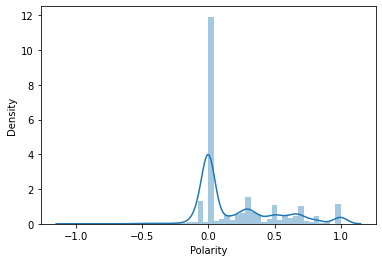

In [23]:
sns.distplot(df["Polarity"],hist=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


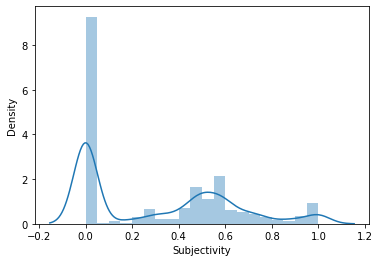

In [24]:
sns.distplot(df["Subjectivity"],hist=True)

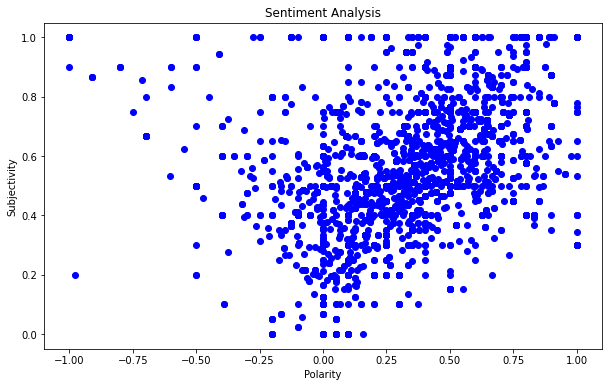

In [25]:
# plot the polarity and subjectivity
plt.figure(figsize = (10,6))
for i in range(0,df.shape[0]):
  plt.scatter(df['Polarity'][i],df['Subjectivity'][i],color = "Blue")
 
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

### Distribution of Sentiment Score Across Categories


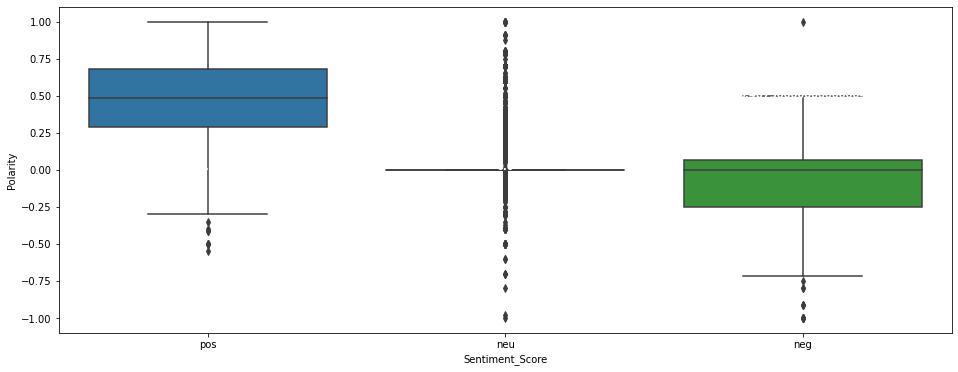

In [26]:
fig,ax = plt.subplots(figsize=(16,6))
 
fig = sns.boxplot(x = 'Sentiment_Score',y='Polarity', data = df)
 
medians = df.groupby(['Sentiment_Score'])['Polarity'].median()
vertical_offset = df['Polarity'].median() * 0.05
 
for xtick in fig.get_xticks():
    fig.text(xtick,medians[xtick] + vertical_offset,medians[xtick], horizontalalignment='center',color='w',weight='semibold')
 
plt.show()

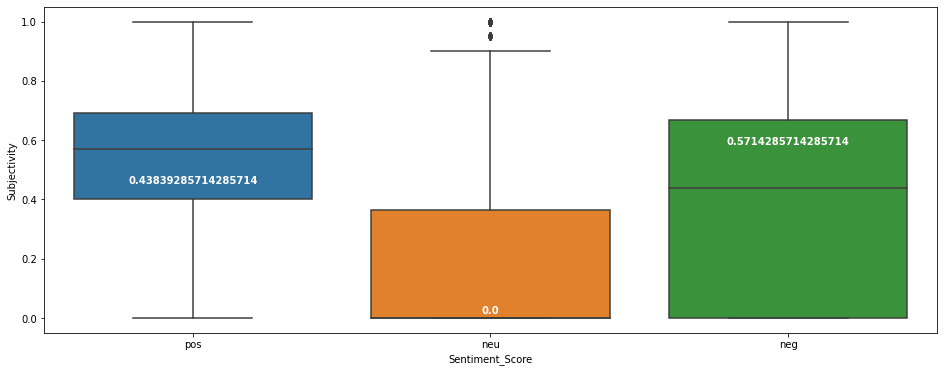

In [27]:
fig,ax = plt.subplots(figsize=(16,6))
 
fig = sns.boxplot(x = 'Sentiment_Score',y='Subjectivity', data = df)
 
medians = df.groupby(['Sentiment_Score'])['Subjectivity'].median()
vertical_offset = df['Subjectivity'].median() * 0.05
 
for xtick in fig.get_xticks():
    fig.text(xtick,medians[xtick] + vertical_offset,medians[xtick], horizontalalignment='center',color='w',weight='semibold')
 
plt.show()

In [28]:
mean = np.mean(df['Polarity']) 
std = np.std(df['Polarity']) 
print('Mean of the Polarity :', mean) 
print('STD Deviation of Polarity :', std)
threshold = 1500
outlier = [] 
for i in range(df.shape[0]): 
    z = (i-mean)/std 
    if z > threshold: 
        outlier.append(i) 
print('Outlier in the dataset:', outlier)

Mean of the Polarity : 0.2094003790317075
STD Deviation of Polarity : 0.315893189913189
Outlier in the dataset: [475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 65

## Distribution of sentiment polarity score by recommendations


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


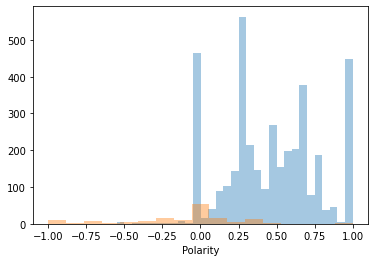

In [29]:
xpos = df.loc[df['Sentiment_Score']== 'pos','Polarity']
xneg = df.loc[df['Sentiment_Score']== 'neg','Polarity']
 
fig, ax = plt.subplots()
 
for i in [xpos,xneg]:
    sns.distplot(i, ax=ax, kde=False)
     
plt.show()

## The distribution of Social Network

In [30]:
df.groupby('SocialNetwork').describe()

Subjectivity                           ... Polarity                
                     count      mean       std  min  ...      25%  50%   75%  max
SocialNetwork                                        ...                         
FACEBOOK             450.0  0.423284  0.407856  0.0  ...      0.0  0.0  0.60  1.0
INSTAGRAM           1363.0  0.210685  0.316059  0.0  ...      0.0  0.0  0.25  1.0
TWITTER             5259.0  0.390102  0.302329  0.0  ...      0.0  0.2  0.50  1.0
YouTube Inf         2920.0  0.180618  0.290747  0.0  ...      0.0  0.0  0.20  1.0

[4 rows x 16 columns]

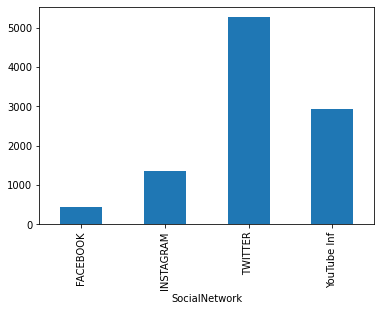

In [31]:
df.groupby('SocialNetwork')['Message'].count().plot(kind = "bar")

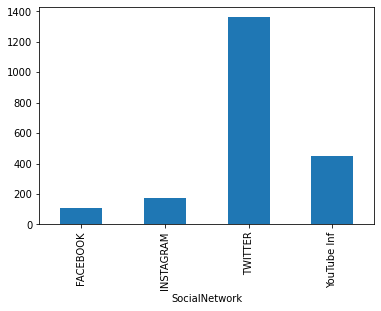

In [32]:
df.groupby('SocialNetwork')['Polarity'].sum().plot(kind = "bar")

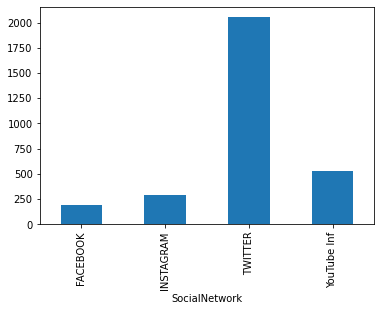

In [33]:
df.groupby('SocialNetwork')['Subjectivity'].sum().plot(kind = "bar")

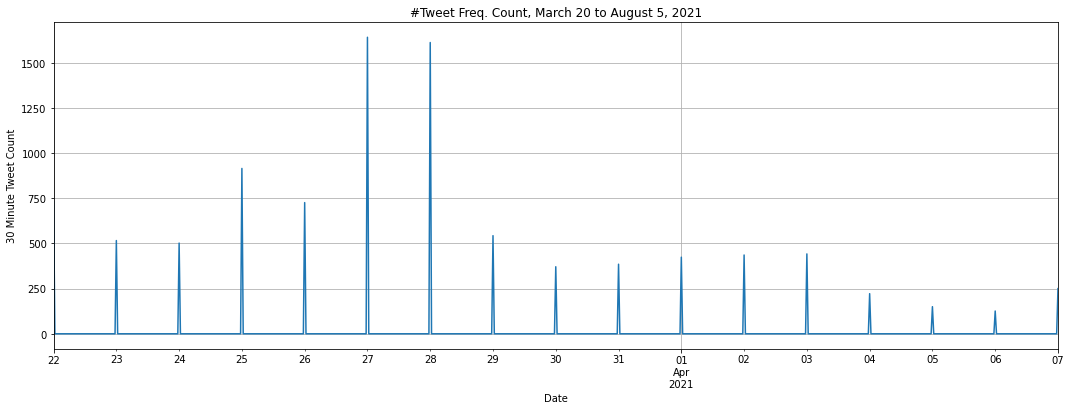

In [34]:
from datetime import datetime
df["Date"]= pd.to_datetime(df["Date"])
newdf = df.groupby(pd.Grouper(key='Date', freq='30 min', convention='start')).size()
newdf.plot(figsize=(18,6))
plt.ylabel('30 Minute Tweet Count')
plt.title('#Tweet Freq. Count, March 20 to August 5, 2021')
plt.grid(True)

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(df['Sentiment_Score'],df['Polarity'], test_size=0.50, random_state=0)
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

model_gb = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),('tfidf', TfidfTransformer()),('gb', GradientBoostingClassifier(n_estimators=50)),])

model_gb.fit(Train_X, Train_Y)

Y_Pred = np.array(Test_Y)

predicted = model_gb.predict(Test_X)
print('accuracy %s' % accuracy_score(Y_Pred, Test_Y))

accuracy 1.0
